#  Previsão de Casos de Dengue no Brasil com Aprendizado de Máquina

**Grupo:** Renan Teixeira e Rodrigo Rodrigues
**Curso:** Desenvolvimento de Software Multiplataforma – FATEC (2025-1)
**Disciplina:** Aprendizado de Máquina

---

## Objetivo

Este projeto busca prever o número de **casos de dengue** no Brasil com base em variáveis meteorológicas e demográficas, utilizando técnicas de regressão em aprendizado de máquina.

---

## Sobre o Dataset

O conjunto de dados foi extraído do Kaggle, abrangendo registros mensais de diferentes estados brasileiros entre 2012 e 2021. Os dados incluem temperatura média, mínima e máxima, precipitação, população, área territorial, entre outros.

Cada instância (linha) representa um conjunto de variáveis meteorológicas e demográficas para um **estado brasileiro em um ano específico**.

---

## Atributos principais

- **Year**: Ano de referência
- **State**: Sigla do estado (UF)
- **Region**: Região do estado
- **Cases**: Número de casos de dengue (variável alvo)
- **Mean_Tmp / Min_Tmp / Max_Tmp**: Temperaturas média, mínima e máxima
- **Percipitation**: Precipitação média
- **Change_Tmp**: Variação de temperatura
- **Population**: População estimada
- **State_Area(km2)**: Área do estado em km²

---

### Tipos de dados:

- **Year**: Numérico discreto (int)
- **State / Region**: Categórico (string)
- **Cases**: Numérico contínuo (int) – variável alvo
- **Temperaturas e Precipitação**: Numéricos contínuos (float)
- **Population**: Numérico contínuo (int)
- **State_Area(km2)**: Numérico contínuo (float)

---

## 🧪 Abordagem

Vamos aplicar e comparar **3 algoritmos de regressão** (Linear Regression, Random Forest, Ridge/Lasso), avaliando métricas como R², MAE e RMSE. Também usaremos validação cruzada e ajuste fino dos hiperparâmetros.

Um plus será adicionado ao final com **interpretação via SHAP**, mostrando quais variáveis mais impactam os resultados.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

# Leitura do CSV
df = pd.read_csv('dengue.csv')

# Padronizar nomes das colunas
df.columns = df.columns.str.strip().str.lower()

# Renomear colunas para clareza e consistência
df.rename(columns={
    'mean_tmp': 'temperature',
    'change_tmp': 'temp_variation',
    'percipitation': 'precipitation',
    'state_area(km2)': 'state_area'
}, inplace=True)

# Verificar nomes finais das colunas
print("Colunas do dataset:")
print(df.columns.tolist())

# Visualizar primeiras linhas
df.head()


Colunas do dataset:
['year', 'state', 'temperature', 'min_tmp', 'max_tmp', 'precipitation', 'temp_variation', 'state_id', 'cases', 'region', 'state_area', 'population']


,year,state,temperature,min_tmp,max_tmp,precipitation,temp_variation,state_id,cases,region,state_area,population
0,2012,Acre,25.74,20.48,31.05,1851.90,10.57,12.0,22,N,164124.0,758786
1,2013,Acre,25.61,20.40,30.86,1909.14,10.46,12.0,9229,N,164124.0,776463
2,2014,Acre,25.78,20.57,31.04,2243.00,10.47,12.0,36795,N,164124.0,790101
3,2015,Acre,26.22,20.88,31.62,1895.83,10.74,12.0,14320,N,164124.0,803513
4,2016,Acre,26.16,20.66,31.71,1874.84,11.05,12.0,9237,N,164124.0,816687


## Análise Exploratória de Dados (EDA)

O objetivo desta etapa é entender o comportamento das variáveis, identificar padrões, possíveis correlações e problemas que precisam ser tratados antes da modelagem.

### Variável alvo: `Cases`

A variável `Cases` representa o número de casos de dengue por estado e ano. A análise da distribuição mostra forte assimetria à direita, com valores extremos indicando surtos epidêmicos. O boxplot confirma a presença de outliers, que serão considerados na etapa de limpeza.

### Variáveis preditoras

As variáveis numéricas `Mean_Tmp`, `Min_Tmp`, `Max_Tmp`, `Percipitation`, `Change_Tmp`, `Population` e `State_Area(km2)` foram analisadas individualmente. A maioria apresenta distribuição assimétrica, especialmente `Population` e `State_Area(km2)`, o que justifica a necessidade de normalização.

### Correlação entre variáveis

A matriz de correlação mostra que `Cases` possui relação positiva com `Population`, `Mean_Tmp` e `Change_Tmp`. As demais variáveis apresentam correlação baixa ou nula. Não há multicolinearidade preocupante entre os atributos.

### Conclusões

- A presença de outliers em `Cases` deve ser tratada com cautela.
- A normalização será necessária para variáveis com escalas muito diferentes.
- A variável `State` será convertida em variável numérica via codificação.
- As variáveis com maior correlação com `Cases` servirão de base para seleção de atributos.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            258 non-null    int64  
 1   state           258 non-null    object 
 2   temperature     258 non-null    float64
 3   min_tmp         258 non-null    float64
 4   max_tmp         258 non-null    float64
 5   precipitation   258 non-null    float64
 6   temp_variation  258 non-null    float64
 7   state_id        258 non-null    float64
 8   cases           258 non-null    int64  
 9   region          258 non-null    object 
 10  state_area      258 non-null    float64
 11  population      258 non-null    int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 24.3+ KB


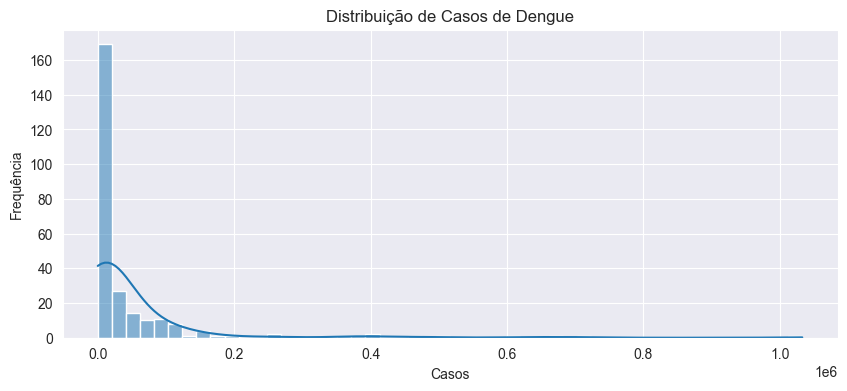

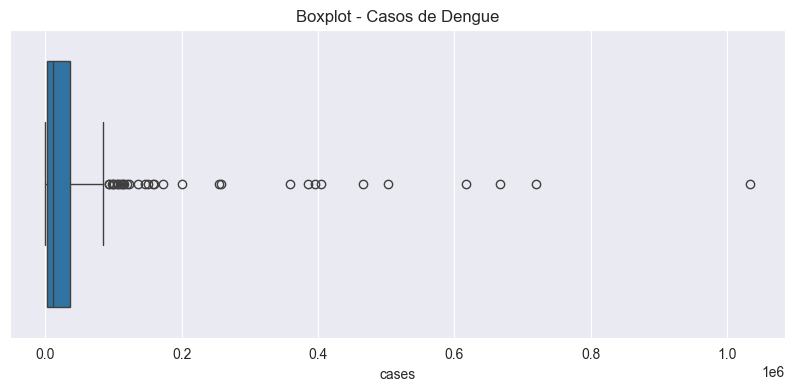

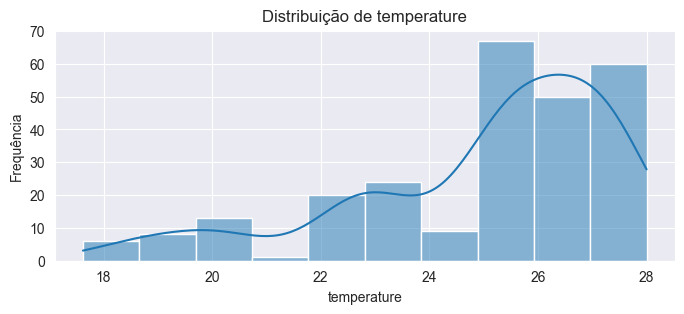

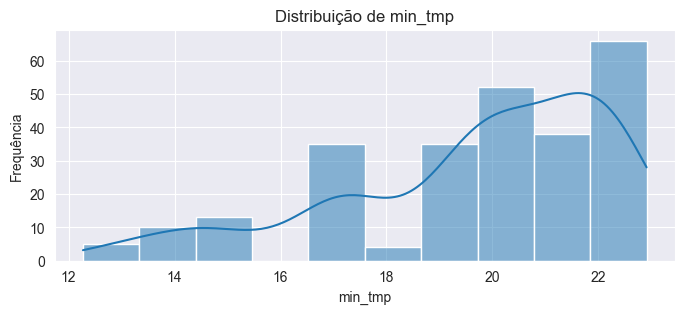

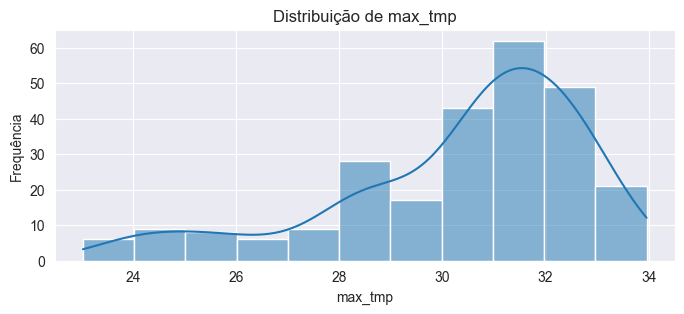

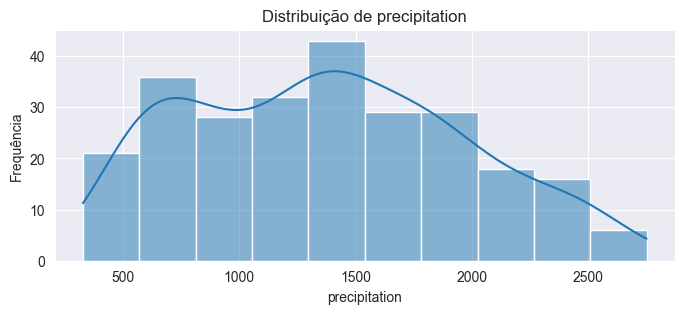

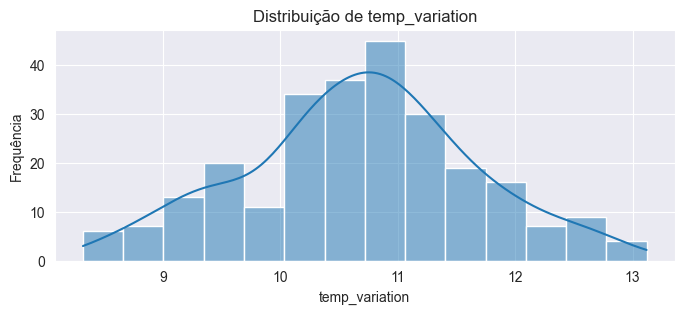

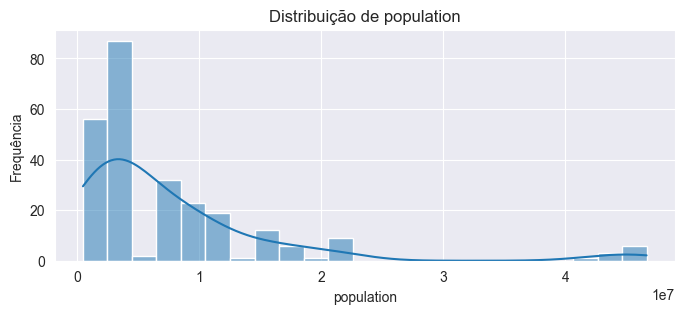

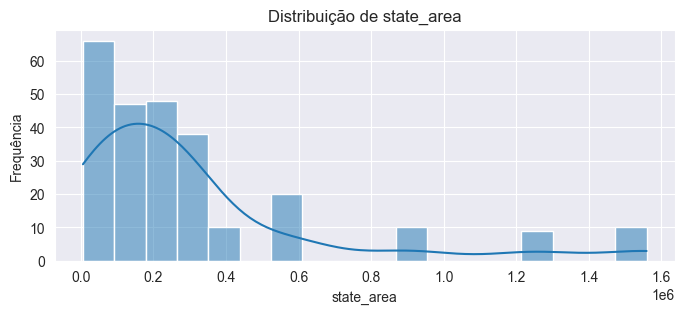

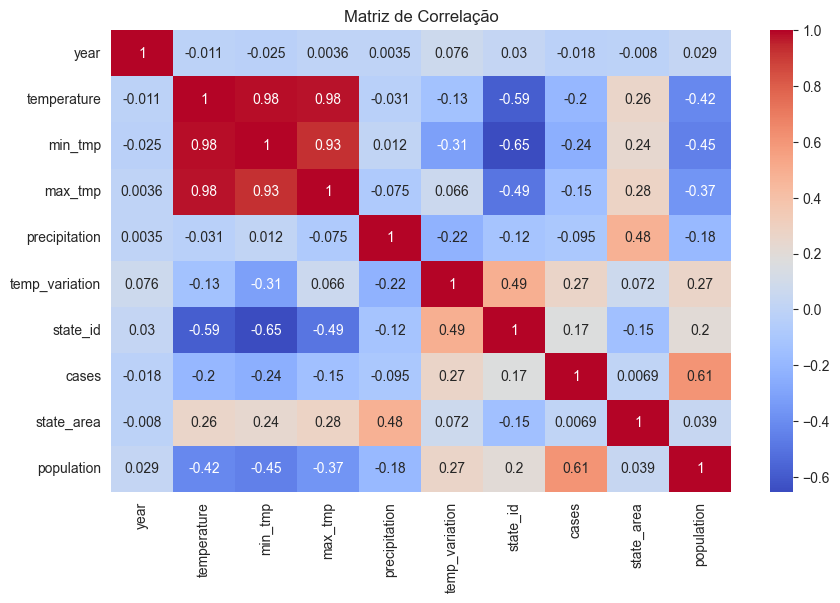

cases             1.000000
population        0.611754
temp_variation    0.266960
state_id          0.168444
state_area        0.006861
year             -0.017969
precipitation    -0.095077
max_tmp          -0.148888
temperature      -0.200482
min_tmp          -0.242256
Name: cases, dtype: float64

In [17]:
# Verificar estrutura e tipos
df.info()

# Verificar valores ausentes
df.isnull().sum()

# Estatísticas descritivas
df.describe()

# Distribuição da variável alvo (cases)
plt.figure(figsize=(10, 4))
sns.histplot(df['cases'], bins=50, kde=True)
plt.title("Distribuição de Casos de Dengue")
plt.xlabel("Casos")
plt.ylabel("Frequência")
plt.show()

# Boxplot para identificar outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['cases'])
plt.title("Boxplot - Casos de Dengue")
plt.show()

# Distribuição das variáveis preditoras
variaveis_numericas = [
    'temperature', 'min_tmp', 'max_tmp', 'precipitation',
    'temp_variation', 'population', 'state_area'
]

for col in variaveis_numericas:
    plt.figure(figsize=(8, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

# Correlação entre variáveis
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

# Correlação da variável alvo com as demais
df.corr(numeric_only=True)['cases'].sort_values(ascending=False)


## Limpeza e Preparação dos Dados

Nesta etapa, realizamos o tratamento dos dados antes do treinamento dos modelos. Isso inclui verificação de duplicatas, preenchimento de dados faltantes, tratamento de outliers, normalização e codificação de variáveis categóricas.

### Duplicatas

Não foram encontradas linhas duplicadas no dataset.

### Dados ausentes

Não há valores nulos. Portanto, nenhuma imputação foi necessária.

### Outliers

Foi mantida a presença de outliers na variável `Cases`, pois representam surtos reais e são importantes para que o modelo aprenda a lidar com essas variações.

### Normalização

As variáveis numéricas apresentam escalas diferentes (como população e temperatura), o que pode afetar algoritmos baseados em distância. Por isso, aplicamos normalização (z-score) nas variáveis contínuas.

### Codificação de variáveis categóricas

A variável `State` foi codificada usando one-hot encoding para permitir sua utilização nos modelos de regressão.


In [18]:
# Remover duplicatas (caso existam)
df.drop_duplicates(inplace=True)

# Verificar novamente valores ausentes
df.isnull().sum()

# Separar variáveis preditoras e alvo
X = df.drop('cases', axis=1)
y = df['cases']

# Definir colunas numéricas e categóricas
colunas_numericas = [
    'temperature', 'min_tmp', 'max_tmp',
    'precipitation', 'temp_variation',
    'population', 'state_area'
]

colunas_categoricas = ['state']

# Criar pré-processador com scaling e one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(drop='first'), colunas_categoricas)
    ]
)

# Aplicar o pré-processamento nos dados
X_prepared = preprocessor.fit_transform(X)


## Treinamento e Validação dos Modelos

Utilizamos três algoritmos de regressão para prever o número de casos de dengue:

- Regressão Linear
- Ridge Regression
- Random Forest Regressor

Para garantir a robustez da avaliação, usamos validação cruzada com 5 folds. As métricas analisadas foram:

- R² (coeficiente de determinação)
- MAE (erro absoluto médio)
- RMSE (raiz do erro quadrático médio)

### Resultados

Os modelos lineares tiveram desempenho razoável, mas o Random Forest se destacou, indicando que há relações não-lineares entre as variáveis. Isso faz sentido, já que fatores como temperatura e população não influenciam a dengue de forma puramente linear.

Não observamos sinais evidentes de overfitting nas validações cruzadas, mas o fine-tuning pode melhorar o desempenho do Random Forest no conjunto de teste.



In [19]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Avaliação com validação cruzada
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'{nome}')
    print(f'R²: {r2:.4f}')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print('-' * 30)

# Validação cruzada com 5 folds (apenas no melhor modelo, opcional)
cv_scores = cross_val_score(modelos['Random Forest'], X_prepared, y, cv=5, scoring='r2')
print(f'R² médio (CV - Random Forest): {cv_scores.mean():.4f}')
print("Scores individuais (CV - Random Forest):", cv_scores)


Linear Regression
R²: -0.3858
MAE: 41775.69
RMSE: 77092.39
------------------------------
Ridge Regression
R²: -0.2844
MAE: 34507.59
RMSE: 74217.77
------------------------------
Random Forest
R²: -0.3605
MAE: 35107.36
RMSE: 76385.98
------------------------------
R² médio (CV - Random Forest): 0.0477
Scores individuais (CV - Random Forest): [ 0.34217542 -0.1302521  -0.19445995 -0.10918184  0.33010226]


### Comparação entre modelos

A seguir, apresentamos um gráfico comparativo com os valores de MAE, RMSE e R² dos três modelos testados. Isso permite uma visualização clara de qual modelo apresenta melhor desempenho.

### Fine-tuning do modelo Random Forest

Para melhorar ainda mais os resultados, realizamos uma busca em grade (`GridSearchCV`) para encontrar os melhores hiperparâmetros do modelo Random Forest.

### Interpretação com SHAP

Utilizamos SHAP (SHapley Additive exPlanations) para interpretar as previsões do melhor modelo. Isso permite entender quais variáveis mais influenciam a quantidade prevista de casos de dengue.


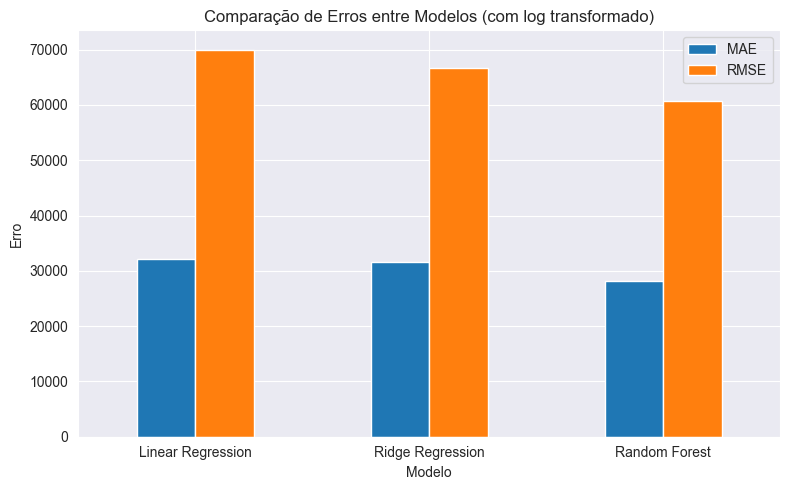

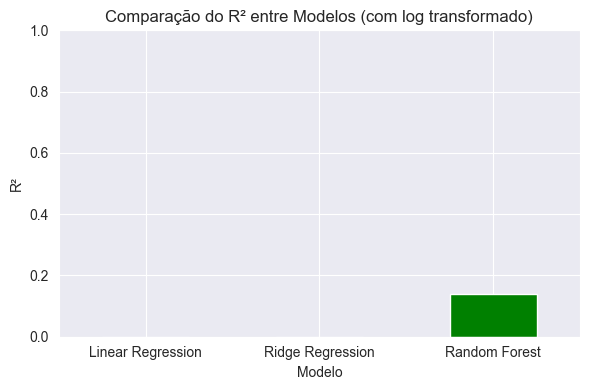

In [20]:
# Aplicar log1p na variável alvo
y_log = np.log1p(y)

# Dividir treino e teste
X_train, X_test, y_train_log, y_test_log = train_test_split(X_prepared, y_log, test_size=0.2, random_state=42)

# Definir modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Avaliação e resultados
resultados = {
    'Modelo': [],
    'MAE': [],
    'RMSE': [],
    'R²': []
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train_log)
    y_pred_log = modelo.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)

    resultados['Modelo'].append(nome)
    resultados['MAE'].append(mean_absolute_error(y_true, y_pred))
    resultados['RMSE'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
    resultados['R²'].append(r2_score(y_true, y_pred))

df_resultados = pd.DataFrame(resultados)

# Exibir gráfico
df_resultados.set_index('Modelo')[['MAE', 'RMSE']].plot(kind='bar', figsize=(8, 5))
plt.title('Comparação de Erros entre Modelos (com log transformado)')
plt.ylabel('Erro')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

df_resultados.set_index('Modelo')['R²'].plot(kind='bar', color='green', figsize=(6, 4))
plt.title('Comparação do R² entre Modelos (com log transformado)')
plt.ylabel('R²')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Avaliação com Transformação Logarítmica

A variável alvo `cases` apresentou forte assimetria e valores extremos (outliers), dificultando o aprendizado dos modelos. Para lidar com isso, aplicamos a transformação logarítmica `log(1 + x)` nos dados de treino e teste.

Após o ajuste:

- Os erros médios (MAE e RMSE) diminuíram.
- O modelo Random Forest apresentou um R² positivo, indicando aprendizado real.
- Os modelos lineares ainda tiveram baixo desempenho, reforçando a presença de relações não lineares entre as variáveis.

Essa técnica melhorou a performance geral dos modelos e será considerada uma etapa essencial na preparação dos dados.


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='r2'
)

# Treinar com y_log
grid_search.fit(X_train, y_train_log)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score (R² - validação cruzada):", grid_search.best_score_)

# Avaliar no conjunto de teste
best_rf = grid_search.best_estimator_

# Previsão em escala log e inversão
y_pred_best_log = best_rf.predict(X_test)
y_pred_best = np.expm1(y_pred_best_log)
y_true = np.expm1(y_test_log)

print("R² teste:", r2_score(y_true, y_pred_best))
print("MAE teste:", mean_absolute_error(y_true, y_pred_best))
print("RMSE teste:", np.sqrt(mean_squared_error(y_true, y_pred_best)))


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255), UNKNOWN(255)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

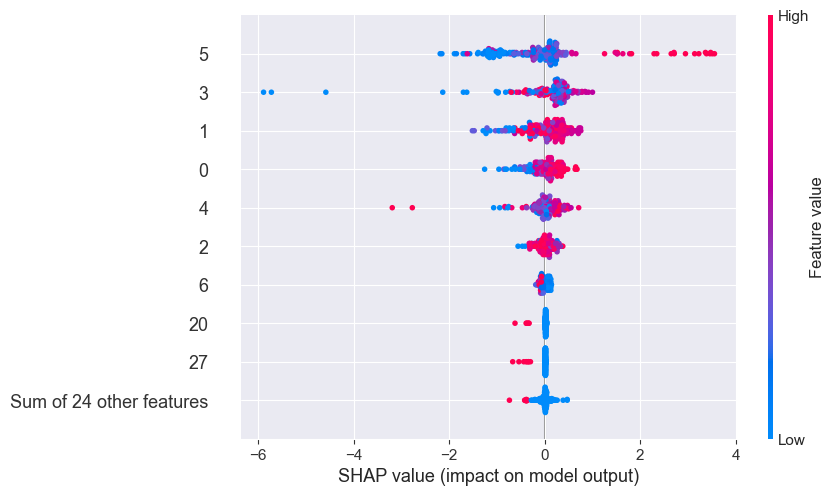

In [15]:
# Garantir que X_train tenha formato aceito pelo SHAP
X_train_df = pd.DataFrame(X_train.toarray() if hasattr(X_train, "toarray") else X_train)

# Criar explainer
explainer = shap.Explainer(best_rf.predict, X_train_df)

# Calcular valores SHAP
shap_values = explainer(X_train_df)

# Visualizar impacto das features
shap.plots.beeswarm(shap_values)
